#Wikipedia movie plots - Drama or comedy?

dataset from https://www.kaggle.com/datasets/jrobischon/wikipedia-movie-plots

Data scraped from wikipedia summaries of movie plots around the world. We will drop all of them aside from dramas and comedies. 

In [69]:
from google.colab import files
uploaded = files.upload()

In [70]:
import pandas as pd
df = pd.read_csv('wiki_movie_plots_deduped.csv')

In [71]:
df.tail()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
34881,2014,The Water Diviner,Turkish,Director: Russell Crowe,Director: Russell Crowe\r\nCast: Russell Crowe...,unknown,https://en.wikipedia.org/wiki/The_Water_Diviner,"The film begins in 1919, just after World War ..."
34882,2017,Çalgı Çengi İkimiz,Turkish,Selçuk Aydemir,"Ahmet Kural, Murat Cemcir",comedy,https://en.wikipedia.org/wiki/%C3%87alg%C4%B1_...,"Two musicians, Salih and Gürkan, described the..."
34883,2017,Olanlar Oldu,Turkish,Hakan Algül,"Ata Demirer, Tuvana Türkay, Ülkü Duru",comedy,https://en.wikipedia.org/wiki/Olanlar_Oldu,"Zafer, a sailor living with his mother Döndü i..."
34884,2017,Non-Transferable,Turkish,Brendan Bradley,"YouTubers Shanna Malcolm, Shira Lazar, Sara Fl...",romantic comedy,https://en.wikipedia.org/wiki/Non-Transferable...,The film centres around a young woman named Am...
34885,2017,İstanbul Kırmızısı,Turkish,Ferzan Özpetek,"Halit Ergenç, Tuba Büyüküstün, Mehmet Günsür, ...",romantic,https://en.wikipedia.org/wiki/%C4%B0stanbul_K%...,The writer Orhan Şahin returns to İstanbul aft...


We dont need most of this, lets simplify it.
We will remove all but the sentiment column and text collumn, and change it so sentiment either holds 1 for negative or 0 for anything else

In [72]:
# Select only the 'Genre' and 'Plot' columns
df = df[['Genre', 'Plot']]

# Remove any columns that have null values
df = df.dropna(axis=1)

# Map 'comedy' to 1 and 'drama' to 0 in the 'Genre' column
df.loc[df['Genre'] == 'comedy', 'Genre'] = 1
df.loc[df['Genre'] == 'drama', 'Genre'] = 0

# Filter rows where the 'Genre' column contains either '0' or '1'
df = df[df['Genre'].isin([0, 1])]

# Convert the 'Genre' column to integer
df['Genre'] = df['Genre'].astype(int)

df.head()

,Genre,Plot
7,1,The film is about a family who move to the sub...
14,1,Before heading out to a baseball game at a nea...
15,1,The plot is that of a black woman going to the...
16,0,On a beautiful summer day a father and mother ...
17,0,A thug accosts a girl as she leaves her workpl...


In [73]:
df.shape


(10343, 2)

In [74]:
num_ones = (df['Genre'] == 1).sum()
num_non_ones = (df['Genre'] != 1).sum()
print(f'Number of comedies: {num_ones}')
print(f'Number of dramas: {num_non_ones}')
print(num_ones/10343)

Number of comedies: 4379
Number of dramas: 5964
0.4233781301363241


#Graphs: 0 is drama, 1 is comedy.

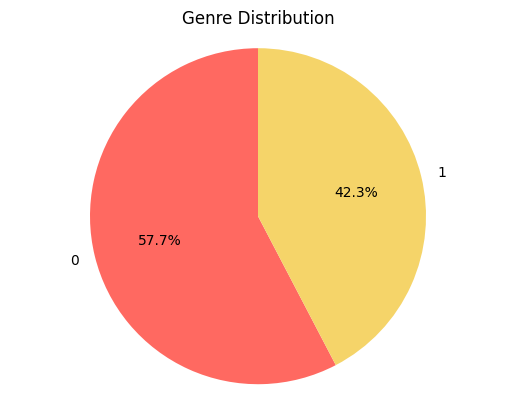

In [75]:
import matplotlib.pyplot as plt
# Group the data by Genre and count the number of occurrences
sentiment_counts = df.groupby('Genre').size()

# Create a pie chart of the sentiment distribution
labels = [0, 1]
colors = ['#FF6961', '#F5D469']
plt.pie(sentiment_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Genre Distribution')
plt.show()

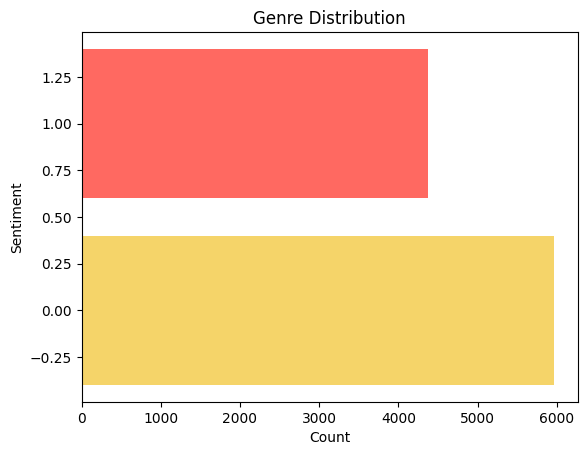

In [76]:
sentiment_counts = df['Genre'].value_counts()

fig, ax = plt.subplots()

ax.barh(sentiment_counts.index, sentiment_counts.values, color=['#F5D469', '#FF6961'])

ax.set_xlabel('Count')
ax.set_ylabel('Sentiment')
ax.set_title('Genre Distribution')

plt.show()

#Vectorize and split the data
We use min_df to limit the feature size set to only words that appear in atleast 20 different summaries. This cuts feature count from 200k down to 8k

In [101]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models

In [102]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

stopwords = (stopwords.words('english'))
vectorizer = TfidfVectorizer(stop_words=stopwords, min_df = 20)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [103]:
from sklearn.model_selection import train_test_split

# Split data into X and y
X = df['Plot']
y = df['Genre']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [104]:
# apply tfidf vectorizer
X_train = vectorizer.fit_transform(X_train).toarray()  # fit and transform the train data
X_test = vectorizer.transform(X_test).toarray()        # transform only the test data

In [105]:
X_test.shape


(2069, 7805)

#Sequential Neural Network using TFIDF bag of words


In [107]:
# build the model
from keras.layers import Dense, Dropout

model = models.Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [111]:
# compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [133]:
# create a validation set
x_val = X_train[:2000]
partial_x_train = X_train[2000:]

y_val = y_train[:2000]
partial_y_train = y_train[2000:]

type(x_val)

numpy.ndarray

In [134]:
# train

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/10
13/13 [==============================] - 1s 106ms/step - loss: 0.0051 - accuracy: 0.9997 - val_loss: 0.0335 - val_accuracy: 0.9845
Epoch 2/10
13/13 [==============================] - 1s 81ms/step - loss: 0.0054 - accuracy: 0.9995 - val_loss: 0.0341 - val_accuracy: 0.9855
Epoch 3/10
13/13 [==============================] - 2s 127ms/step - loss: 0.0059 - accuracy: 0.9992 - val_loss: 0.0347 - val_accuracy: 0.9855
Epoch 4/10
13/13 [==============================] - 2s 133ms/step - loss: 0.0061 - accuracy: 0.9987 - val_loss: 0.0351 - val_accuracy: 0.9855
Epoch 5/10
13/13 [==============================] - 1s 102ms/step - loss: 0.0066 - accuracy: 0.9990 - val_loss: 0.0359 - val_accuracy: 0.9845
Epoch 6/10
13/13 [==============================] - 1s 110ms/step - loss: 0.0050 - accuracy: 0.9997 - val_loss: 0.0350 - val_accuracy: 0.9845
Epoch 7/10
13/13 [==============================] - 1s 48ms/step - loss: 0.0049 - accuracy: 0.9997 - val_loss: 0.0362 - val_accuracy: 0.9840
Epoch 8/

In [135]:
# use sklearn evaluation

from sklearn.metrics import classification_report

pred = model.predict(X_test)
pred = [1.0 if p>= 0.5 else 0.0 for p in pred]
print(classification_report(y_test, pred))

65/65 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.78      0.79      0.79      1194
           1       0.71      0.70      0.71       875

    accuracy                           0.75      2069
   macro avg       0.75      0.75      0.75      2069
weighted avg       0.75      0.75      0.75      2069



In [136]:
# use tf evaluation method

losses_and_metrics = model.evaluate(X_test, y_test, batch_size=128)
losses_and_metrics

17/17 [==============================] - 0s 6ms/step - loss: 1.5024 - accuracy: 0.7545


[1.5023869276046753, 0.7544707655906677]

In [137]:
# to extract predictions, use this code

classes = model.predict(X_test, batch_size=128)
classes[:5]

17/17 [==============================] - 0s 10ms/step


array([[4.1939300e-01],
       [8.8804700e-07],
       [9.9995953e-01],
       [2.6709367e-08],
       [9.7224144e-03]], dtype=float32)

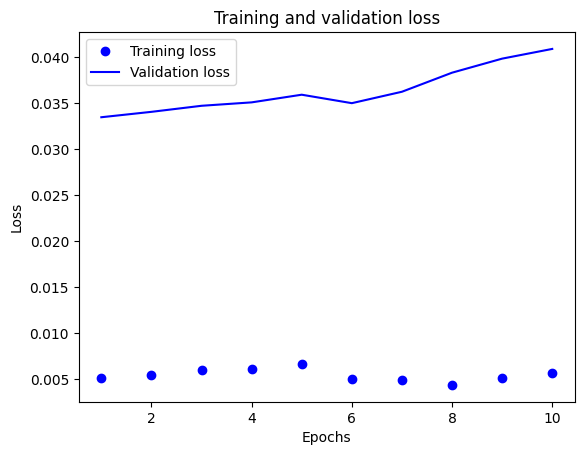

In [139]:
# plot the training and validation loss
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

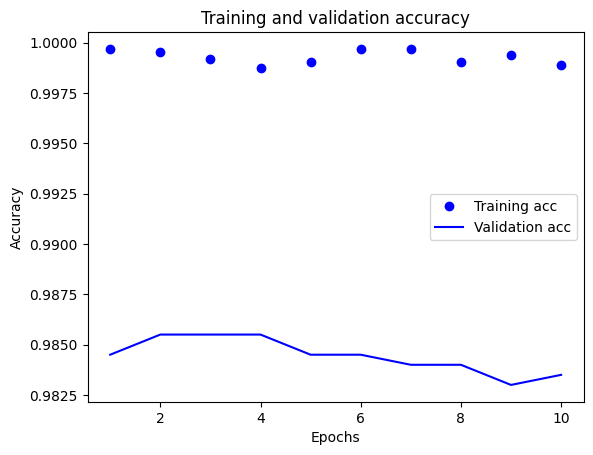

In [140]:
# plot the training and validation accuracy

plt.clf()   # clear

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [142]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # min change in metrics
    patience=4,     # min epochs 
    restore_best_weights=True,
)

In [143]:
# fit the model again with early stopping

model.fit(X_train, y_train, callbacks=[early_stopping], batch_size=512)
results = model.evaluate(X_test, y_test)

16/17 [===========================>..] - ETA: 0s - loss: 0.0213 - accuracy: 0.9938

65/65 [==============================] - 0s 5ms/step - loss: 1.4204 - accuracy: 0.7545


In [144]:
# model.evaluate() results give the loss and metrics (accuracy in this example)
results

[1.4204189777374268, 0.7544707655906677]

In [146]:
pred = model.predict(X_test)
pred = [1.0 if p>= 0.5 else 0.0 for p in pred]
print(classification_report(y_test, pred))

65/65 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.80      0.77      0.78      1194
           1       0.70      0.73      0.72       875

    accuracy                           0.75      2069
   macro avg       0.75      0.75      0.75      2069
weighted avg       0.76      0.75      0.76      2069



In [147]:
# check the pos/neg distribution
# the set is 50/50

pos = sum(y_test[y_test>0]) / len(y_test)
pos

0.42290961817303047

#Recurrent Neural Network using Keras embedding

In [165]:
# build the model

model = models.Sequential()
model.add(layers.Embedding(3000, 32))
model.add(layers.SimpleRNN(32))
model.add(layers.Dense(1, activation='sigmoid'))

In [166]:
# compile
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [167]:
# Split data into X and y
X = df['Plot']
y = df['Genre']


In [168]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 1000 # maximum length of sequences
max_words = 3000 # maximum number of words in the vocabulary

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X) # texts is your array of strings

sequences = tokenizer.texts_to_sequences(X) # convert texts to sequences
train_data = pad_sequences(sequences, maxlen=maxlen) # pad sequences to have the same length
X_train, X_test, y_train, y_test = train_test_split(train_data, y, test_size=0.2, random_state=42)

In [170]:
history = model.fit(X_train,
                    y_train,
                    epochs=5,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/5
52/52 [==============================] - 20s 380ms/step - loss: 0.5922 - accuracy: 0.6737 - val_loss: 0.7424 - val_accuracy: 0.6248
Epoch 2/5
52/52 [==============================] - 19s 365ms/step - loss: 0.4546 - accuracy: 0.7811 - val_loss: 0.6694 - val_accuracy: 0.6689
Epoch 3/5
52/52 [==============================] - 20s 389ms/step - loss: 0.2958 - accuracy: 0.8806 - val_loss: 0.6962 - val_accuracy: 0.6580
Epoch 4/5
52/52 [==============================] - 19s 364ms/step - loss: 0.2005 - accuracy: 0.9394 - val_loss: 0.7380 - val_accuracy: 0.6483
Epoch 5/5
52/52 [==============================] - 20s 388ms/step - loss: 0.1240 - accuracy: 0.9725 - val_loss: 0.8118 - val_accuracy: 0.6447


In [172]:
pred = model.predict(X_test)
pred = [1.0 if p>= 0.5 else 0.0 for p in pred]
print(classification_report(y_test, pred))

65/65 [==============================] - 7s 97ms/step
              precision    recall  f1-score   support

           0       0.69      0.81      0.74      1194
           1       0.65      0.50      0.57       875

    accuracy                           0.68      2069
   macro avg       0.67      0.65      0.65      2069
weighted avg       0.67      0.68      0.67      2069



In [173]:
# use tf evaluation method

losses_and_metrics = model.evaluate(X_test, y_test, batch_size=128)
losses_and_metrics

17/17 [==============================] - 1s 71ms/step - loss: 0.7540 - accuracy: 0.6767


[0.753950297832489, 0.6766554117202759]

In [174]:
# to extract predictions, use this code

classes = model.predict(X_test, batch_size=128)
classes[:5]

17/17 [==============================] - 1s 76ms/step


array([[0.8675869 ],
       [0.04675532],
       [0.75008315],
       [0.07404325],
       [0.2773489 ]], dtype=float32)

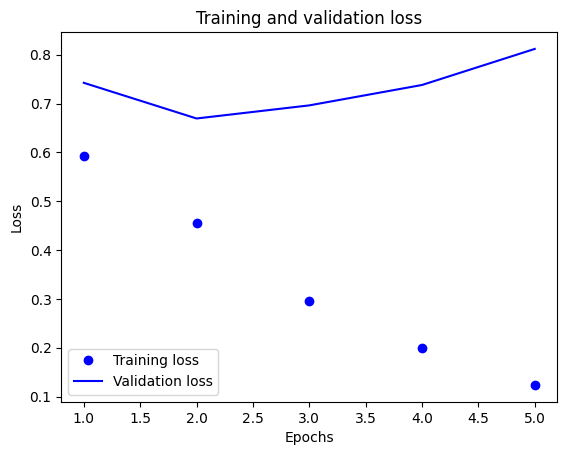

In [175]:
# plot the training and validation loss
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

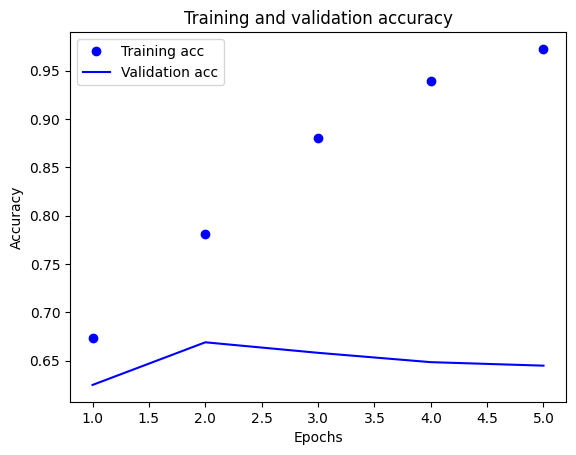

In [176]:
# plot the training and validation accuracy

plt.clf()   # clear

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [177]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # min change in metrics
    patience=4,     # min epochs 
    restore_best_weights=True,
)

In [178]:
# fit the model again with early stopping

model.fit(X_train, y_train, callbacks=[early_stopping], batch_size=512)
results = model.evaluate(X_test, y_test)

17/17 [==============================] - ETA: 0s - loss: 0.2277 - accuracy: 0.9204

65/65 [==============================] - 3s 49ms/step - loss: 0.7897 - accuracy: 0.6559


In [179]:
# model.evaluate() results give the loss and metrics (accuracy in this example)
results

[0.7896972894668579, 0.6558724045753479]

In [180]:
pred = model.predict(X_test)
pred = [1.0 if p>= 0.5 else 0.0 for p in pred]
print(classification_report(y_test, pred))

65/65 [==============================] - 5s 71ms/step
              precision    recall  f1-score   support

           0       0.66      0.81      0.73      1194
           1       0.63      0.44      0.52       875

    accuracy                           0.66      2069
   macro avg       0.65      0.63      0.63      2069
weighted avg       0.65      0.66      0.64      2069



In [181]:
# check the pos/neg distribution
# the set is 50/50

pos = sum(y_test[y_test>0]) / len(y_test)
pos

0.42290961817303047

#Convolutional Neural Network using Keras embedding

In [182]:
# build a Sequential model 1D convnet

model = models.Sequential()
model.add(layers.Embedding(max_features, 128, input_length=maxlen)) 
model.add(layers.Conv1D(32, 7, activation='relu')) 
model.add(layers.MaxPooling1D(5)) 
model.add(layers.Conv1D(32, 7, activation='relu')) 
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

In [183]:
# compile
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [184]:
# Split data into X and y
X = df['Plot']
y = df['Genre']


In [185]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 1000 # maximum length of sequences
max_words = 3000 # maximum number of words in the vocabulary

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X) # texts is your array of strings

sequences = tokenizer.texts_to_sequences(X) # convert texts to sequences
train_data = pad_sequences(sequences, maxlen=maxlen) # pad sequences to have the same length
X_train, X_test, y_train, y_test = train_test_split(train_data, y, test_size=0.2, random_state=42)

In [186]:
history = model.fit(X_train,
                    y_train,
                    epochs=5,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/5
52/52 [==============================] - 57s 1s/step - loss: 0.6874 - accuracy: 0.5785 - val_loss: 0.6728 - val_accuracy: 0.5698
Epoch 2/5
52/52 [==============================] - 58s 1s/step - loss: 0.5999 - accuracy: 0.6782 - val_loss: 0.7828 - val_accuracy: 0.5764
Epoch 3/5
52/52 [==============================] - 55s 1s/step - loss: 0.4921 - accuracy: 0.7879 - val_loss: 0.6023 - val_accuracy: 0.7015
Epoch 4/5
52/52 [==============================] - 55s 1s/step - loss: 0.3981 - accuracy: 0.8445 - val_loss: 0.6183 - val_accuracy: 0.7287
Epoch 5/5
52/52 [==============================] - 58s 1s/step - loss: 0.3084 - accuracy: 0.8939 - val_loss: 0.7035 - val_accuracy: 0.7227


In [187]:
pred = model.predict(X_test)
pred = [1.0 if p>= 0.5 else 0.0 for p in pred]
print(classification_report(y_test, pred))

65/65 [==============================] - 5s 74ms/step
              precision    recall  f1-score   support

           0       0.78      0.75      0.77      1194
           1       0.68      0.72      0.70       875

    accuracy                           0.74      2069
   macro avg       0.73      0.73      0.73      2069
weighted avg       0.74      0.74      0.74      2069



In [188]:
# use tf evaluation method

losses_and_metrics = model.evaluate(X_test, y_test, batch_size=128)
losses_and_metrics

17/17 [==============================] - 3s 195ms/step - loss: 0.6454 - accuracy: 0.7351


[0.6453810334205627, 0.7351377606391907]

In [189]:
# to extract predictions, use this code

classes = model.predict(X_test, batch_size=128)
classes[:5]

17/17 [==============================] - 5s 278ms/step


array([[0.32836944],
       [0.05604642],
       [0.9919017 ],
       [0.13305807],
       [0.70219874]], dtype=float32)

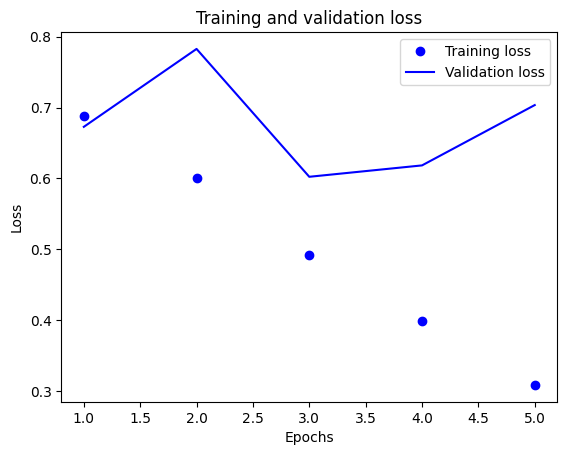

In [190]:
# plot the training and validation loss
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

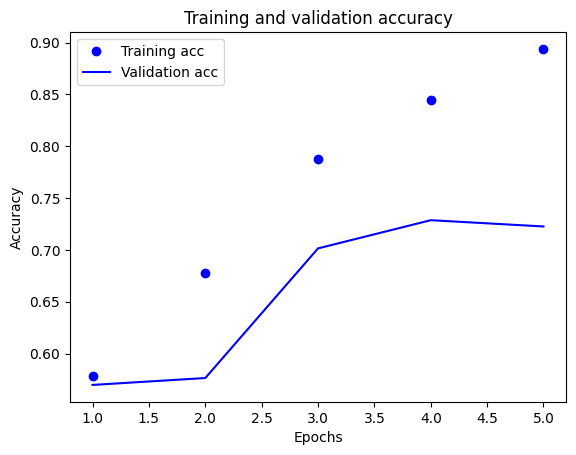

In [191]:
# plot the training and validation accuracy

plt.clf()   # clear

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Results
There were some interesting results. my initial guess was that recurrent neural network would be the most successful- and perhaps it would have, but I made certain concessions in order to make the program to run quickly.

one of the reasons I think RNN failed so badly was that i limited the vocabulary size in the vectorizer to 3000 so i wouldn't be waiting hours for the networks to train.

The general performance in this assignemnt is as follows:

Bag of Words simple NN and CNN both got 75% ish accuracy,
RNN only got ~65%.

The expected accuracy would have been about 55% for a naive guess. 

RNN and CNN took considerably longer to run then the CNN, and thus I used fewer epochs.

I can see why LLMs require so many computational resources now.
Overfitting definitely seemed to be an issue- my training data size was ~10k large, so perhaps it was too small?

Either way, the system seems to work, but for this application a bag of words is probably plenty.